In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [29]:
# ref: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

# a 2d list of training sets, where each index should contains array of 3 elements
train_tweet_id_list = []
train_text_list = []
train_q1_label_list = []

# read train file with utf-8
train_file = open("../data/covid_training.tsv", "r", encoding="utf-8")
train_list = train_file.readlines()
train_file.close()

# remove headear row
del train_list[0]

# put every training set with tweet_id, text, and q1_label into 2d array
for row in train_list:
    train_string_list = str(row).split("\t")
    train_tweet_id_list.append(train_string_list[0])
    train_text_list.append(train_string_list[1].lower())
    train_q1_label_list.append(train_string_list[2])
    
# Tokenizing text with scikit-learn, min_df ignore words that have less than 2 occurrences
count_vect = CountVectorizer(min_df=2)
X_train_counts = count_vect.fit_transform(train_text_list)

# From occurrences to frequencies
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# read test file with utf-8
test_file = open("../data/covid_test_public.tsv", "r", encoding="utf-8")
test_list = test_file.readlines()
test_file.close()

# a 2d list of testing sets, where each index should contains array of 3 elements
test_tweet_id_list = []
test_text_list = []
test_q1_label_list = []

# put every testing set with tweet_id, text, and q1_label into 2d array
for row in test_list:
    test_string_list = str(row).split("\t")
    test_tweet_id_list.append(test_string_list[0])
    test_text_list.append(test_string_list[1].lower())
    test_q1_label_list.append(test_string_list[2])

# Training a classifier
clf = MultinomialNB(alpha=0.01).fit(X_train_tfidf, train_q1_label_list)

X_new_counts = count_vect.transform(test_text_list)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

pred_yes, pred_no, test_yes, test_no = [], [], [], []

# splitting the values by class for yes and no labels
for elem in range(0, len(test_q1_label_list)):
    if predicted[elem] == 'yes':
        pred_yes.append(predicted[elem])
        test_yes.append(test_q1_label_list[elem])
    else:
        pred_no.append(predicted[elem])
        test_no.append(test_q1_label_list[elem])

# calculating score for class and which is more frequent
best_label = 'yes' if len(pred_yes) > len(pred_no) else 'no'
best_label_score = ((len(pred_yes)/(len(pred_no)+len(pred_yes)))*100) if best_label == 'yes' else ((len(pred_no)/(len(pred_yes)+len(pred_no)))*100)

# calculating metric scores
precision_no = precision_score(test_q1_label_list, predicted, pos_label="no")
precision_yes = precision_score(test_q1_label_list, predicted, pos_label="yes")
recall_no = recall_score(test_q1_label_list, predicted, pos_label="no")
recall_yes = recall_score(test_q1_label_list, predicted, pos_label="yes")
f1_no = f1_score(test_q1_label_list, predicted, pos_label="no")
f1_yes = f1_score(test_q1_label_list, predicted, pos_label="yes")

accuracy = accuracy_score(test_q1_label_list, predicted)

# Output
output_trace_file = open("../output/trace_NB-BOW-FV.txt", "w")
for id, predict, result in zip(test_tweet_id_list, predicted, test_q1_label_list):
    output_trace_file.writelines(('{}  {}  {}  {}  {}\r').format(id, best_label, best_label_score, result,  ("correct" if (predict == result) else "wrong")))
output_trace_file.close()

# ref: https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics
output_eval_file = open("../output/eval_NB-BOW-FV.txt", "w")
output_eval_file.write(
    ('{}\r{}\r{}  {}\r{}  {}\r{}  {}\r'.format(('Format for per class is yes followed by no.'), accuracy, precision_yes, precision_no, recall_yes, recall_no, f1_yes, f1_no ))
)
output_eval_file.close()

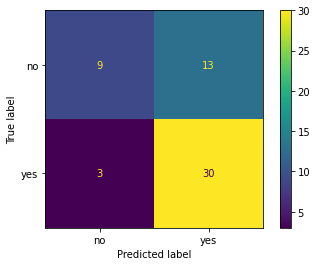

In [30]:
print(plot_confusion_matrix(clf, X_new_tfidf, test_q1_label_list))

In [31]:
print(classification_report(test_q1_label_list, predicted))

              precision    recall  f1-score   support

          no       0.75      0.41      0.53        22
         yes       0.70      0.91      0.79        33

    accuracy                           0.71        55
   macro avg       0.72      0.66      0.66        55
weighted avg       0.72      0.71      0.69        55

